In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for age estimation(multi-task)

This notebook shows how to train and sample from a Neural Process for a class of age estimation in multi-task learning way
There are (num_of_persons) tasks.
In each task, there are (num_of_images) context points

### Read Dataset

In [2]:
from datasets.datasets import FaceFeatureData

# Create dataset

num_of_people = 3
num_of_images=18
dataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images)

#82 different people(batch_num)
#18 different images each people(batch_size)
#x_dim = 2048

### Build Neural Process

In [3]:
from model.NeuralProcessModel import NeuralProcess

x_dim = 2048
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Train Neural Process 1st time
the first time(all the parameter will be updated)

Epoch: 0, Avg_loss: 17121.37890625
Epoch: 1, Avg_loss: 16566.189778645832
Epoch: 2, Avg_loss: 16179.400065104166
Epoch: 3, Avg_loss: 15715.857096354166
Epoch: 4, Avg_loss: 14888.388509114584
Epoch: 5, Avg_loss: 14351.728841145834
Epoch: 6, Avg_loss: 13331.585286458334
Epoch: 7, Avg_loss: 12505.55322265625
Epoch: 8, Avg_loss: 11577.793619791666
Epoch: 9, Avg_loss: 10716.630696614584
Epoch: 10, Avg_loss: 9654.476236979166
Epoch: 11, Avg_loss: 8387.767903645834
Epoch: 12, Avg_loss: 7474.56494140625
Epoch: 13, Avg_loss: 6424.453043619792
Epoch: 14, Avg_loss: 5253.017333984375
Epoch: 15, Avg_loss: 4511.838948567708
Epoch: 16, Avg_loss: 3856.5540771484375
Epoch: 17, Avg_loss: 3195.994588216146
Epoch: 18, Avg_loss: 2650.579305013021
Epoch: 19, Avg_loss: 2121.4417114257812
Epoch: 20, Avg_loss: 1649.1208089192708
Epoch: 21, Avg_loss: 1218.8615112304688
Epoch: 22, Avg_loss: 1043.995096842448
Epoch: 23, Avg_loss: 764.7054138183594
Epoch: 24, Avg_loss: 623.8581034342448
Epoch: 25, Avg_loss: 516.85

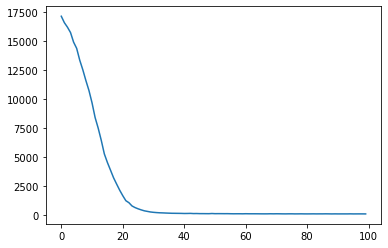

In [4]:
from torch.utils.data import DataLoader
from trainer.NP_trainer import NeuralProcessTrainer
from data_loader.data_loader import FGNetDataLoader

batch_size = 1
num_context = 17
num_target = 1

data_loader = FGNetDataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  data_loader=data_loader)

neuralprocess.training = True
np_trainer.train(100)
#save first model parameters trained on the whole dataset
torch.save(neuralprocess.state_dict(), r'D:\PycharmProjects\ANP\neural-processes\trained_models\age_estimation\firstWholeTrained.ckpt')
plt.plot(range(len(np_trainer.epoch_loss_history)),np_trainer.epoch_loss_history)
plt.show()


### Train Neural Process 2nd time
(the parameter of encoder will be frozen)

the structure of neural process network(3-layer network):
layer 1: xy_to_r

layer 2: r_to_mu_sigma

layer 3: xz_to_y


Epoch: 0, Avg_loss: 79.34986877441406
Epoch: 1, Avg_loss: 79.95647684733073
Epoch: 2, Avg_loss: 80.99722544352214
Epoch: 3, Avg_loss: 81.26151529947917
Epoch: 4, Avg_loss: 78.57335408528645
Epoch: 5, Avg_loss: 80.57682545979817
Epoch: 6, Avg_loss: 80.59007008870442
Epoch: 7, Avg_loss: 81.58545684814453
Epoch: 8, Avg_loss: 78.63992055257161
Epoch: 9, Avg_loss: 81.8279800415039
Epoch: 10, Avg_loss: 79.53356170654297
Epoch: 11, Avg_loss: 79.82288614908855
Epoch: 12, Avg_loss: 78.41611226399739
Epoch: 13, Avg_loss: 78.36003112792969
Epoch: 14, Avg_loss: 78.36930338541667
Epoch: 15, Avg_loss: 82.11442057291667
Epoch: 16, Avg_loss: 80.58349863688152
Epoch: 17, Avg_loss: 81.32670338948567
Epoch: 18, Avg_loss: 80.83554331461589
Epoch: 19, Avg_loss: 80.78657786051433
Epoch: 20, Avg_loss: 79.46197255452473
Epoch: 21, Avg_loss: 80.84693908691406
Epoch: 22, Avg_loss: 80.76859792073567
Epoch: 23, Avg_loss: 80.4078877766927
Epoch: 24, Avg_loss: 80.61547342936198
Epoch: 25, Avg_loss: 80.2223307291666

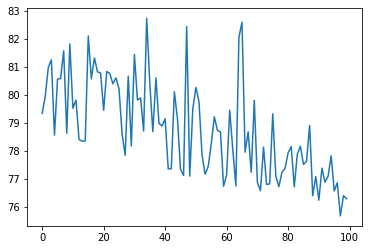

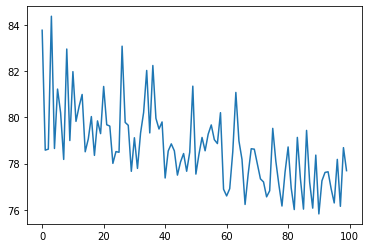

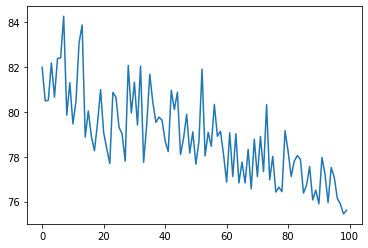

In [5]:
singlePersonDatasets = []
for idx in range(num_of_people):
    singlePersonDataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images,index=idx)
    singlePersonDatasets.append(singlePersonDataset)

for idx, singlePersonDataset in enumerate(singlePersonDatasets):
    #load model

    smallNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
    smallNeuralprocess.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes\trained_models\age_estimation\firstWholeTrained.ckpt'))
    #Freeze the encoder part of each model
    for child in smallNeuralprocess.children():
        for param in child.parameters():
            param.requires_grad = False
        break
    singleData_loader = FGNetDataLoader(singlePersonDataset, batch_size=batch_size, shuffle=True)
    smallOptimizer = torch.optim.Adam(smallNeuralprocess.parameters(), lr=3e-5)
    smallNp_trainer = NeuralProcessTrainer(device, smallNeuralprocess, smallOptimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  data_loader=data_loader)
    smallNeuralprocess.training = True
    smallNp_trainer.train(100)
    #save first model parameters trained on the whole dataset
    path = r'D:\PycharmProjects\ANP\neural-processes\trained_models\age_estimation\smallTrained\smallTrained' + str(idx) + r'.ckpt'
    torch.save(smallNeuralprocess.state_dict(),path)
    plt.plot(range(len(smallNp_trainer.epoch_loss_history)),smallNp_trainer.epoch_loss_history)
    plt.show()



### Construct input to MergeNet
Let new dataset(new person who is not in trainset)

In [6]:
from trainer.NP_trainer import NeuralProcessTrainer
from datasets.datasets import FaceFeatureTestData
import os


for batch in data_loader:
    break
# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ =  NeuralProcessTrainer.context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

modelPath = r'D:\PycharmProjects\ANP\neural-processes\trained_models\age_estimation\smallTrained'
models = os.listdir(modelPath)
smallModels = map(lambda x: os.path.join(modelPath, x), models)

num_of_test_images = 18
test_target = 0
resultsOnPretrainedModelsList = [] 
for idx, root_dir in enumerate(smallModels):
    #load model
    testNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
    testModelPath = r'D:\PycharmProjects\ANP\neural-processes\trained_models\age_estimation\smallTrained\smallTrained' + str(idx) + r'.ckpt'
    testNeuralprocess.load_state_dict(torch.load(testModelPath))
    testNeuralprocess.training = False

    testDataset = FaceFeatureTestData()
    testData_loader = FGNetDataLoader(testDataset, batch_size=batch_size, shuffle=True)
    resultsOnPretrainedModel = []
    for x_target, y_target in testData_loader:
        test_target = y_target
        avg_mu = 0
        for i in range(10):
            p_y_pred = testNeuralprocess(x_context, y_context, x_target)
            # Extract mean of distribution
            mu = p_y_pred.loc.detach()
            avg_mu += mu
        avg_mu = avg_mu / 10
        avg_mu = avg_mu.view(18)
        resultsOnPretrainedModel.append(avg_mu.tolist())
    resultsOnPretrainedModelsList.append(resultsOnPretrainedModel)

resultsOnPretrainedModels = []
for i in range(num_of_test_images):
    resultsWithSinglePerson = []
    for list in resultsOnPretrainedModelsList:
        resultsWithSinglePerson.append(list[0][i])
    resultsOnPretrainedModels.append(resultsWithSinglePerson)
resultsOnPretrainedModels = torch.FloatTensor(resultsOnPretrainedModels)

### Training MergeNet

Epoch: 0, loss: 6012.859375
Epoch: 1, loss: 5983.330078125
Epoch: 2, loss: 5953.87939453125
Epoch: 3, loss: 5924.5068359375
Epoch: 4, loss: 5895.2158203125
Epoch: 5, loss: 5866.00537109375
Epoch: 6, loss: 5836.87841796875
Epoch: 7, loss: 5807.833984375
Epoch: 8, loss: 5778.876953125
Epoch: 9, loss: 5750.00634765625
Epoch: 10, loss: 5721.22314453125
Epoch: 11, loss: 5692.5283203125
Epoch: 12, loss: 5663.92333984375
Epoch: 13, loss: 5635.408203125
Epoch: 14, loss: 5606.986328125
Epoch: 15, loss: 5578.65771484375
Epoch: 16, loss: 5550.42138671875
Epoch: 17, loss: 5522.28076171875
Epoch: 18, loss: 5494.2353515625
Epoch: 19, loss: 5466.2861328125
Epoch: 20, loss: 5438.43310546875
Epoch: 21, loss: 5410.67919921875
Epoch: 22, loss: 5383.02294921875
Epoch: 23, loss: 5355.46484375
Epoch: 24, loss: 5328.0078125
Epoch: 25, loss: 5300.64990234375
Epoch: 26, loss: 5273.392578125
Epoch: 27, loss: 5246.23681640625
Epoch: 28, loss: 5219.1826171875
Epoch: 29, loss: 5192.22998046875
Epoch: 30, loss: 516

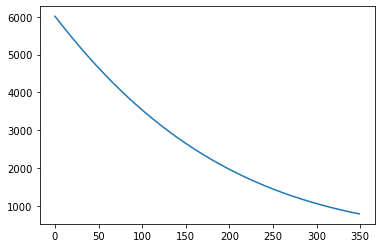

In [7]:
from model.models import MergeNet

mergeNet = MergeNet(number_of_trained_people=3)
mergeOptimizer = torch.optim.Adam(mergeNet.parameters(), lr=3e-3)
mergeEpoch = 350
criterion = torch.nn.MSELoss()
test_target = test_target.view(num_of_test_images,1)
merge_loss_history = []
for epoch in range(mergeEpoch):
    mergeOptimizer.zero_grad()
    mergeResult = mergeNet(resultsOnPretrainedModels)
    loss = criterion(mergeResult, test_target)
    loss.backward()
    mergeOptimizer.step()
    print("Epoch: {}, loss: {}".format(epoch, loss))
    merge_loss_history.append(loss)
plt.plot(range(len(merge_loss_history)),merge_loss_history)
plt.show()
#save mergeNet
path = r'D:\PycharmProjects\ANP\neural-processes\trained_models\mergeNet.ckpt'
torch.save(mergeNet.state_dict(),path)

In [8]:
from datasets import datasets

finalTestDataset = FaceFeatureTestData(r'D:\PycharmProjects\ANP\neural-processes\datasets\FinalTestFeatureVector')
finalTestData_loader = FGNetDataLoader(finalTestDataset, batch_size=batch_size, shuffle=True)
finalResultsOnPretrainedModels = datasets.ConstructInputToMergeNet(num_of_test_images,finalTestData_loader)
testMergeNet = MergeNet(number_of_trained_people=3)
testMergeNet.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes\trained_models\mergeNet.ckpt'))

final_predict_value = testMergeNet(finalResultsOnPretrainedModels)
print('final result: ')
print(final_predict_value)
for _,target_y in finalTestData_loader:
    print(target_y)


final result: 
tensor([[23.5265],
        [22.7685],
        [22.5175],
        [22.6414],
        [23.0012],
        [23.4279],
        [23.5582],
        [22.8146],
        [24.2936],
        [23.7903],
        [23.1151],
        [23.4348],
        [23.1670],
        [22.6671],
        [23.3699],
        [23.7932],
        [22.9102],
        [22.8789]], grad_fn=<AddmmBackward>)
tensor([[[37.],
         [23.],
         [22.],
         [26.],
         [ 1.],
         [18.],
         [45.],
         [26.],
         [37.],
         [45.],
         [22.],
         [ 1.],
         [38.],
         [18.],
         [23.],
         [38.],
         [38.],
         [39.]]])
tensor([[[31.],
         [30.],
         [24.],
         [18.],
         [35.],
         [40.],
         [52.],
         [45.],
         [40.],
         [40.],
         [61.],
         [49.],
         [48.],
         [52.],
         [52.],
         [49.],
         [31.],
         [35.]]])
